# [ LG에너지솔루션 DX Expert 양성과정 ]

## 시계열 데이터 분석을 위한 딥러닝

### 강의 복습
강의자료 : 시계열 데이터 분석을 위한 딥러닝

- `Anomaly Detection`: 일부 기간 데이터를 입력으로 하여 해당 상황의 정상/비정상 여부를 탐지
- `Transformer`: Transformer는 Sequence를 입력으로 받아 sequenc를 출력하는 구조이므로, 시계열 과업에도 적용 가능
- `Representation learning` : 시계열의 의미 있는 정보를 더 쉽게 추출할 수 있도록 고차원의 raw data를 저 차원 공간에 mapping하는 것을 목표, 비지도 학습 방식으로 해당 데이터의 representation을 학습하고, 이를 downstreamtask에서 활용하는 방식

<img src="https://github.com/hwk0702/2024_LG_ES_External_Lecture/blob/main/240703_Transformer/image/AD01.png?raw=true" width="800">

### 실습 요약

1. 본 실습에서는 Transformer를 활용한 representation learning 모델인 TS2Vec을 활용하여 시계열 이상탐지를 수행합니다.
2. Unlabeled data로 부터 Positive / Negative pair를 구축하여 contrastive learning을 통해 pre-training을 수행합니다.
3. 이상탐지 과업을 수행하도록 fine-tuning을 진행합니다.
4. 해당 모델에 대한 전체적인 구조는 강의자료 17 page에서 확인하실 수 있습니다.

[Yue, Zhihan, et al. "Ts2vec: Towards universal representation of time series." Proceedings of the AAAI Conference on Artificial Intelligence. Vol. 36. No. 8. 2022.](https://ojs.aaai.org/index.php/AAAI/article/view/20881)

<img src="https://github.com/hwk0702/2024_LG_ES_External_Lecture/blob/main/240703_Transformer/image/ts2vec01.png?raw=true" width="600">

---

### STEP 0. 환경 구축하기

- 필요한 library들을 import 합니다.

In [4]:
# github에서 데이터 불러오기
# !git clone https://github.com/yuezhihan/ts2vec.git
%cd ./ts2vec

/dsba/External_Lecture/2024/2024_LG_ES_External_Lecture/240709_DL4TS/ts2vec


/opt/conda/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [16]:
import os
import sys
from urllib import request
import zipfile
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
import dateutil
import math
from sklearn.preprocessing import MinMaxScaler, StandardScaler  # 데이터 전처리를 위한 스케일링 모듈
from sklearn.metrics import confusion_matrix, precision_score, recall_score, fbeta_score
from sklearn.model_selection import KFold

import torch
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn as nn

from models import TSEncoder
from models.losses import hierarchical_contrastive_loss
from utils import init_dl_program, name_with_datetime, pkl_save, data_dropout
from utils import take_per_row, split_with_nan, centerize_vary_length_series, torch_pad_nan

import warnings
warnings.filterwarnings("ignore")

#check torch version & device
print ("Python version:[%s]."%(sys.version))
print ("PyTorch version:[%s]."%(torch.__version__))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = init_dl_program(1, seed=42, max_threads=None)
print ("device:[%s]."%(device)) # device에 cuda:0가 프린트 된다면 GPU를 사용하는 상태입니다

Python version:[3.10.14 (main, May  6 2024, 19:42:50) [GCC 11.2.0]].
PyTorch version:[2.3.1+cu121].
device:[cuda:1].


In [17]:
# set random seed 
def set_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)
    
random_seed = 42
set_seed(random_seed)

In [22]:
class Config:
    # dataset 관련 parameters
    datadir = './data'
    past = 720
    future = 72
    train_ratio = 0.715
    step = 6
    
    # model 관련 paremeters
    output_dims = 64
    hidden_dims = 64
    depth = 10
    
    # training 관련 parameters
    epochs = 100
    batch_size = 256
    test_batch_size = 256
    learning_rate = 0.001
    num_workers = 2
    log_interval = 2000

    # device
    device = 'cuda'

    # seed
    seed = 223

cfg = Config()

In [23]:
# 데이터셋 다운
url = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
savefile = os.path.join(cfg.datadir, os.path.basename(url))

if not os.path.exists(cfg.datadir):
    os.makedirs(cfg.datadir)
    print('Folder creation complete!')
else:
    print('The folder already exists.')

if not os.path.isfile(savefile):
    request.urlretrieve(url, savefile)
    with zipfile.ZipFile(savefile, 'r') as zip_ref:
        zip_ref.extractall(cfg.datadir)
    print('File creation complete!')
else:
    print('The File already exists.')

# 데이터셋 불러오기
df = pd.read_csv(savefile)

The folder already exists.
The File already exists.


In [27]:
titles = [
    "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vapor concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees",
]

feature_keys = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]

date_time_key = "Date Time"

print(
    "The selected parameters are:",
    ", ".join([titles[i] for i in [0, 1, 5, 7, 8, 10, 11]]),
)
selected_features = [feature_keys[i] for i in [0, 1, 5, 7, 8, 10, 11]]
features = df[selected_features]
features.index = df[date_time_key]

# train 데이터를 기반으로 train/test 데이터에 대하여 minmax scaling 적용
scaler = MinMaxScaler().fit(features)
features = scaler.transform(features)
features = pd.DataFrame(features)

train_split = int(cfg.train_ratio * int(df.shape[0]))
train_data = features.loc[0:train_split - 1]
test_data = features.loc[train_split:]

The selected parameters are: Pressure, Temperature, Saturation vapor pressure, Vapor pressure deficit, Specific humidity, Airtight, Wind speed


In [28]:
start = cfg.past + cfg.future   # 720 + 72 = 792
end = start + train_split   # 792 + 300693 = 301485

x_train = train_data.values
y_train = features.iloc[start:end][[1]]

sequence_length = int(cfg.past / cfg.step)  # 720 / 6 = 120

In [30]:
x_end = len(test_data) - cfg.past - cfg.future   # 119858 - 720 - 72 = 119066

label_start = train_split + cfg.past + cfg.future   # 300693 + 720 + 72 = 301485

x_test = test_data.iloc[:x_end].values
y_test = features.iloc[label_start:][[1]]

In [31]:
class CustomDataset(Dataset):
    def __init__(self, X, y, sequence_length=120, step=6, stride=1):
        self.X = X
        self.y = y
        self.sequence_length = sequence_length
        self.step = step
        self.stride = stride

        self.valid_idxs = [i for i in range(0, len(X)-self.sequence_length*self.step+1)]
        self.valid_idxs = np.array(self.valid_idxs, dtype=np.int32)[::stride]

    def __len__(self):
        return len(self.valid_idxs)

    def __getitem__(self, idx):
        i = self.valid_idxs[idx]
        last = i + self.sequence_length*self.step
        input_sequence = np.array(self.X[i:last:self.step], dtype=np.float32)
        target = np.array(self.y.iloc[i], dtype=np.float32)
        return torch.from_numpy(input_sequence), torch.from_numpy(target)

In [32]:
train_dataset = CustomDataset(x_train, y_train, sequence_length, cfg.step)
test_dataset = CustomDataset(x_test, y_test, sequence_length, cfg.step)

train_loader = DataLoader(dataset=train_dataset, batch_size=cfg.batch_size, shuffle=True, num_workers=cfg.num_workers)
test_loader = DataLoader(dataset=test_dataset, batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers)

In [33]:
print(next(iter(train_loader))[0].shape, next(iter(train_loader))[1].shape)
input_shape = next(iter(train_loader))[0].shape

torch.Size([256, 120, 7]) torch.Size([256, 1])


### STEP 1. 데이터 준비하기

지난 실습에서 전처리한 데이터셋을 불러옵니다.

SWaT 데이터를 활용하여 시계열 이상탐지를 진행합니다.
* 스마트 물 처리 공장 내의 센서 및 액추에이터 데이터로, 펌프와 밸브 등의 작동 상태를 바탕으로 추출된 물의 흐름, 압력, 수위 등 다양한 물리적 변수 포함
* 11일 간 51개 센서에서 수집된 데이터셋이며, 다양한 사이버 공격 시나리오가 포함됨. 이상치는 전체 11일 기간 중 마지막 4일에서 총 41회 발생
* 데이터 크기 및 유형: 11일간의 연속 데이터, 946,722개의 데이터 포인트, 이상 비율 11.98%
* 데이터셋 출처
    * https://itrust.sutd.edu.sg/itrust-labs_datasets/dataset_info/

train 데이터셋의 일부를 validation 데이터셋으로 나눕니다.

In [8]:
# !pip install gdown
import gdown

os.makedirs('../data/SWaT/SWaT.A1 _ A2_Dec 2015/Physical', exist_ok=True)

train_url = 'https://drive.google.com/uc?id=1IYPnLUjaHMzwefzmxErQpb9UYGW_1dpQ'
train_file = '../data/SWaT/SWaT.A1 _ A2_Dec 2015/Physical/SWaT_Dataset_Normal_v1.pkl'  
gdown.download(train_url, train_file, quiet=False)

test_url = 'https://drive.google.com/uc?id=17TUUeUgCgEmPoR372yvg41iuOQzAKtUU'
test_file = '../data/SWaT/SWaT.A1 _ A2_Dec 2015/Physical/SWaT_Dataset_Attack_v0.pkl'  
gdown.download(test_url, test_file, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1IYPnLUjaHMzwefzmxErQpb9UYGW_1dpQ
From (redirected): https://drive.google.com/uc?id=1IYPnLUjaHMzwefzmxErQpb9UYGW_1dpQ&confirm=t&uuid=f1d855ed-e80e-4a59-951c-49d519a929ba
To: /dsba/External_Lecture/2024/2024_LG_ES_External_Lecture/240709_DL4TS/data/SWaT/SWaT.A1 _ A2_Dec 2015/Physical/SWaT_Dataset_Normal_v1.pkl

  0%|                                                                                                              | 0.00/217M [00:00<?, ?B/s]
  0%|▏                                                                                                     | 524k/217M [00:00<01:06, 3.25MB/s]
  2%|█▋                                                                                                   | 3.67M/217M [00:00<00:12, 16.5MB/s]
  4%|████▏                                                                                                | 8.91M/217M [00:00<00:06, 30.8MB/s]
  7%|██████▌                                         

'../data/SWaT/SWaT.A1 _ A2_Dec 2015/Physical/SWaT_Dataset_Attack_v0.pkl'

In [9]:
# 파일 경로 설정
train_path = '../data/SWaT/SWaT.A1 _ A2_Dec 2015/Physical/SWaT_Dataset_Normal_v1.pkl'
test_path = '../data/SWaT/SWaT.A1 _ A2_Dec 2015/Physical/SWaT_Dataset_Attack_v0.pkl'

# 검증 데이터 분할 비율
valid_split_rate = 0.8

# 훈련 데이터셋 로드 및 전처리
trainset = pd.read_pickle(train_path).drop(['Normal/Attack', ' Timestamp'], axis=1)
valid_split_index = int(len(trainset) * valid_split_rate)
validset = trainset.iloc[valid_split_index:].to_numpy()  # 검증 데이터셋
trainset = trainset.iloc[:valid_split_index].to_numpy()  # 훈련 데이터셋
train_timestamp = np.arange(len(trainset))  # 훈련 데이터 타임스탬프
valid_timestamp = np.arange(len(validset))  # 검증 데이터 타임스탬프

# 테스트 데이터셋 로드 및 전처리
testset = pd.read_pickle(test_path)
test_timestamp = np.arange(len(testset))  # 테스트 데이터 타임스탬프
test_label = testset['Normal/Attack'].copy()
test_label[test_label == 'Normal'] = 0
test_label[test_label != 0] = 1
testset = testset.drop(['Normal/Attack', ' Timestamp'], axis=1)
columns = testset.columns.tolist()  # 컬럼 리스트
testset = testset.to_numpy()

# 결과 출력
print(f"Train set size: {len(trainset)}, Validation set size: {len(validset)}, Test set size: {len(testset)}")
print(f"Columns: {columns}")

Train set size: 396000, Validation set size: 99000, Test set size: 449919
Columns: ['FIT101', 'LIT101', ' MV101', 'P101', 'P102', ' AIT201', 'AIT202', 'AIT203', 'FIT201', ' MV201', ' P201', ' P202', 'P203', ' P204', 'P205', 'P206', 'DPIT301', 'FIT301', 'LIT301', 'MV301', 'MV302', ' MV303', 'MV304', 'P301', 'P302', 'AIT401', 'AIT402', 'FIT401', 'LIT401', 'P401', 'P402', 'P403', 'P404', 'UV401', 'AIT501', 'AIT502', 'AIT503', 'AIT504', 'FIT501', 'FIT502', 'FIT503', 'FIT504', 'P501', 'P502', 'PIT501', 'PIT502', 'PIT503', 'FIT601', 'P601', 'P602', 'P603']


In [10]:
pd.DataFrame(trainset)

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,0.0,124.3135,1.0,1.0,1.0,251.9226,8.313446,312.7916,0.000000,1.0,...,0.000000,1.0,1.0,9.100231,0.000000,3.3485,0.000256,1.0,1.0,1.0
1,0.0,124.3920,1.0,1.0,1.0,251.9226,8.313446,312.7916,0.000000,1.0,...,0.000000,1.0,1.0,9.100231,0.000000,3.3485,0.000256,1.0,1.0,1.0
2,0.0,124.4705,1.0,1.0,1.0,251.9226,8.313446,312.7916,0.000000,1.0,...,0.000000,1.0,1.0,9.100231,0.000000,3.3485,0.000256,1.0,1.0,1.0
3,0.0,124.6668,1.0,1.0,1.0,251.9226,8.313446,312.7916,0.000000,1.0,...,0.000000,1.0,1.0,9.100231,0.000000,3.3485,0.000256,1.0,1.0,1.0
4,0.0,124.5098,1.0,1.0,1.0,251.9226,8.313446,312.7916,0.000000,1.0,...,0.000000,1.0,1.0,9.100231,0.000000,3.3485,0.000256,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395995,0.0,718.0115,1.0,2.0,1.0,266.5663,8.380415,332.5045,2.459488,2.0,...,0.306825,2.0,1.0,251.201600,1.041233,190.0955,0.000064,1.0,1.0,1.0
395996,0.0,717.8152,1.0,2.0,1.0,266.5663,8.380415,332.5045,2.461282,2.0,...,0.306761,2.0,1.0,251.201600,1.041233,190.0955,0.000064,1.0,1.0,1.0
395997,0.0,717.3442,1.0,2.0,1.0,266.5663,8.380415,332.2481,2.462051,2.0,...,0.306761,2.0,1.0,251.201600,1.041233,190.0955,0.000064,1.0,1.0,1.0
395998,0.0,716.9124,1.0,2.0,1.0,266.5663,8.380415,332.2481,2.462307,2.0,...,0.306505,2.0,1.0,251.201600,1.041233,190.0955,0.000064,1.0,1.0,1.0


In [11]:
pd.DataFrame(validset)

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,0.000000,715.7740,1.0,2.0,1.0,266.5663,8.380415,332.2481,2.461923,2.0,...,0.306505,2.0,1.0,251.2977,1.009195,190.0955,0.000064,1.0,1.0,1.0
1,0.000000,714.9105,1.0,2.0,1.0,266.5663,8.380415,332.2481,2.461282,2.0,...,0.306505,2.0,1.0,251.2977,1.009195,190.0955,0.000064,1.0,1.0,1.0
2,0.000000,714.1647,1.0,2.0,1.0,266.5663,8.380415,332.2481,2.461282,2.0,...,0.307978,2.0,1.0,251.3618,1.041233,190.1756,0.000064,1.0,1.0,1.0
3,0.000000,713.7329,1.0,2.0,1.0,266.5663,8.380415,332.2481,2.461282,2.0,...,0.307978,2.0,1.0,251.3618,1.121328,190.1756,0.000064,1.0,1.0,1.0
4,0.000000,713.1833,1.0,2.0,1.0,266.5663,8.380415,332.2481,2.461282,2.0,...,0.306761,2.0,1.0,251.3618,1.121328,190.1756,0.000064,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98995,2.460366,523.0430,2.0,2.0,1.0,262.0161,8.396437,328.5055,2.442316,2.0,...,0.308619,2.0,1.0,250.8171,1.778105,189.8552,0.000128,1.0,1.0,1.0
98996,2.448836,522.9645,2.0,2.0,1.0,262.0161,8.396437,328.5055,2.442316,2.0,...,0.308619,2.0,1.0,250.8171,1.778105,189.5027,0.000128,1.0,1.0,1.0
98997,2.434744,522.8860,2.0,2.0,1.0,262.0161,8.396437,328.6337,2.444879,2.0,...,0.308619,2.0,1.0,250.8171,1.778105,189.5027,0.000128,1.0,1.0,1.0
98998,2.428338,522.9252,2.0,2.0,1.0,262.0161,8.396437,328.6337,2.445391,2.0,...,0.308619,2.0,1.0,250.8171,1.649953,189.5027,0.000128,1.0,1.0,1.0


In [12]:
pd.DataFrame(testset)

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,2.427057,522.8467,2.0,2.0,1.0,262.0161,8.396437,328.6337,2.445391,2.0,...,0.307786,2.0,1.0,250.8652,1.649953,189.5988,0.000128,1.0,1.0,1.0
1,2.446274,522.8860,2.0,2.0,1.0,262.0161,8.396437,328.6337,2.445391,2.0,...,0.307786,2.0,1.0,250.8652,1.649953,189.6789,0.000128,1.0,1.0,1.0
2,2.489191,522.8467,2.0,2.0,1.0,262.0161,8.394514,328.6337,2.442316,2.0,...,0.308619,2.0,1.0,250.8812,1.649953,189.6789,0.000128,1.0,1.0,1.0
3,2.534350,522.9645,2.0,2.0,1.0,262.0161,8.394514,328.6337,2.442316,2.0,...,0.308619,2.0,1.0,250.8812,1.649953,189.6148,0.000128,1.0,1.0,1.0
4,2.569260,523.4748,2.0,2.0,1.0,262.0161,8.394514,328.6337,2.443085,2.0,...,0.308619,2.0,1.0,250.8812,1.649953,189.5027,0.000128,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449914,2.559972,519.5495,2.0,2.0,1.0,168.0979,8.638683,301.9226,2.459488,2.0,...,0.306569,2.0,1.0,251.1535,0.865024,189.0220,0.000000,1.0,1.0,1.0
449915,2.549082,520.4131,2.0,2.0,1.0,168.0979,8.638683,301.9226,2.459488,2.0,...,0.306569,2.0,1.0,251.0734,0.865024,188.9259,0.000000,1.0,1.0,1.0
449916,2.531467,520.6878,2.0,2.0,1.0,168.0979,8.638683,301.9226,2.460129,2.0,...,0.306569,2.0,1.0,251.0734,0.865024,188.9259,0.000000,1.0,1.0,1.0
449917,2.521218,520.7271,2.0,2.0,1.0,168.0979,8.638683,301.9226,2.460129,2.0,...,0.307978,2.0,1.0,251.0734,0.865024,188.9259,0.000000,1.0,1.0,1.0


### STEP 3. 데이터 정규화

In [15]:
# StandardScaler 객체 생성
scaler = StandardScaler()

# 데이터를 표준화하기 위해 fit 및 transform 메서드 사용
trainset = scaler.fit_transform(trainset)
validset = scaler.transform(validset)
testset = scaler.transform(testset)

In [16]:
pd.DataFrame(trainset)

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,-1.633424,-3.726977,-1.574134,-1.717948,0.0,-2.254735,-0.756720,-0.755841,-1.721201,-1.674528,...,-15.809964,-16.014907,0.0,-16.107141,-5.571226,-16.031737,-0.095499,0.0,-0.08976,0.0
1,-1.633424,-3.726344,-1.574134,-1.717948,0.0,-2.254735,-0.756720,-0.755841,-1.721201,-1.674528,...,-15.809964,-16.014907,0.0,-16.107141,-5.571226,-16.031737,-0.095499,0.0,-0.08976,0.0
2,-1.633424,-3.725711,-1.574134,-1.717948,0.0,-2.254735,-0.756720,-0.755841,-1.721201,-1.674528,...,-15.809964,-16.014907,0.0,-16.107141,-5.571226,-16.031737,-0.095499,0.0,-0.08976,0.0
3,-1.633424,-3.724129,-1.574134,-1.717948,0.0,-2.254735,-0.756720,-0.755841,-1.721201,-1.674528,...,-15.809964,-16.014907,0.0,-16.107141,-5.571226,-16.031737,-0.095499,0.0,-0.08976,0.0
4,-1.633424,-3.725395,-1.574134,-1.717948,0.0,-2.254735,-0.756720,-0.755841,-1.721201,-1.674528,...,-15.809964,-16.014907,0.0,-16.107141,-5.571226,-16.031737,-0.095499,0.0,-0.08976,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395995,-1.633424,1.058163,-1.574134,0.582090,0.0,0.542808,-0.084158,-0.390647,0.591613,0.575067,...,-0.034630,0.062442,0.0,-0.081502,-0.726376,-0.128631,-0.096786,0.0,-0.08976,0.0
395996,-1.633424,1.056581,-1.574134,0.582090,0.0,0.542808,-0.084158,-0.390647,0.593300,0.575067,...,-0.037926,0.062442,0.0,-0.081502,-0.726376,-0.128631,-0.096786,0.0,-0.08976,0.0
395997,-1.633424,1.052785,-1.574134,0.582090,0.0,0.542808,-0.084158,-0.395397,0.594024,0.575067,...,-0.037926,0.062442,0.0,-0.081502,-0.726376,-0.128631,-0.096786,0.0,-0.08976,0.0
395998,-1.633424,1.049304,-1.574134,0.582090,0.0,0.542808,-0.084158,-0.395397,0.594264,0.575067,...,-0.051099,0.062442,0.0,-0.081502,-0.726376,-0.128631,-0.096786,0.0,-0.08976,0.0


### STEP 3. 데이터셋 및 데이터로더 생성

각 serial 별로 input window를 구성하여 데이터셋, 데이터로더를 생성합니다.

<img src="https://github.com/hwk0702/2024_LG_ES_External_Lecture/blob/main/240709_DL4TS/image/Split_window.png?raw=true" width="600">

In [17]:
class BuildDataset(Dataset):
    """
    Build Dataset
    Parameters
    ----------
    data : ndarray(dtype=float, ndim=2, shape=(time, num of features))
        time-series data
    timestamps : ndarray
        time-series data's timestamp
    window_size : int
        window size for time series condition
    slide_size : int(default=1)
        moving window size
    attacks : ndarray(dtype=np.int, ndim=2, shape=(time,))
        attack label
    model_type : str(default=reconstruction)
        model type (reconstruction, prediction)
    Attributes
    ----------
    ts : ndarray
        time-series data's timestamp
    tag_values : ndarray(dtype=np.float32, ndim=2, shape=(time, num of features))
        time-series data
    window_size : int
        window size for time series condition
    model_type : str
        model type (reconstruction, prediction)
    valid_idxs : list
        first index of data divided by window
    Methods
    -------
    __len__()
        return num of valid windows
    __getitem__(idx)
        return data(given, ts, answer, attack)
    """

    def __init__(self,
                 data: np.ndarray,
                 timestamps: np.ndarray,
                 window_size: int,
                 slide_size: int = 1,
                 attacks: np.ndarray = None,
                 model_type: str = 'reconstruction'):
        """
        init method
        """
        self.ts = np.array(timestamps)
        self.tag_values = np.array(data, dtype=np.float32)
        self.window_size = window_size
        self.model_type = model_type

        # 유효한 window 인덱스를 저장할 리스트
        self.valid_idxs = []
        for L in range(0, len(self.ts) - window_size + 1, slide_size):
            R = L + window_size - (1 if model_type == 'reconstruction' else 0)
            if self._is_valid_window(L, R):
                self.valid_idxs.append(L)
        print(f"# of valid windows: {len(self.valid_idxs)}")

        # 레이블이 주어진 경우 처리
        if attacks is not None:
            self.attacks = np.array(attacks, dtype=np.float32)
            self.with_attack = True
        else:
            self.with_attack = False

    def _is_valid_window(self, L, R):
        """
        window의 유효성을 검사하는 method
        """
        try:
            return dateutil.parser.parse(self.ts[R]) - dateutil.parser.parse(self.ts[L]) == timedelta(seconds=self.window_size - (1 if self.model_type == 'reconstruction' else 0))
        except:
            return self.ts[R] - self.ts[L] == self.window_size - (1 if self.model_type == 'reconstruction' else 0)

    def __len__(self):
        """
        유효한 window의 개수를 반환하는 method
        """
        return len(self.valid_idxs)

    def __getitem__(self, idx: str) -> dict:
        """
        주어진 index에 해당하는 데이터 항목을 반환하는 method
        :return: 데이터 항목 (given, answer, attack)
        """
        i = self.valid_idxs[idx]
        last = i + self.window_size
        item = {"given": torch.from_numpy(self.tag_values[i:last])}
        if self.model_type == 'reconstruction':
            item["answer"] = torch.from_numpy(self.tag_values[i:last])
            if self.with_attack:
                item['attack'] = self.attacks[i:last]
        elif self.model_type == 'prediction':
            item["answer"] = torch.from_numpy(self.tag_values[last])
            if self.with_attack:
                item['attack'] = self.attacks[last]
        return item

In [75]:
# 데이터셋 생성
trn_dataset = BuildDataset(trainset, train_timestamp, cfg.window_size, cfg.slide_size,
                           attacks=None, model_type=cfg.model_type)

dev_dataset = BuildDataset(validset, valid_timestamp, cfg.window_size, cfg.slide_size,
                            attacks=None, model_type=cfg.model_type)

tst_dataset = BuildDataset(testset, test_timestamp, cfg.window_size, 1,
                            attacks=test_label, model_type=cfg.model_type)

# of valid windows: 7919
# of valid windows: 1979
# of valid windows: 449820


In [76]:
# 데이터로더 생성
trn_dataloader = torch.utils.data.DataLoader(trn_dataset,
                                             batch_size=cfg.batch_size,
                                             shuffle=True,
                                             num_workers=cfg.num_workers,
                                             drop_last=False)

dev_dataloader = torch.utils.data.DataLoader(dev_dataset,
                                             batch_size=cfg.batch_size,
                                             shuffle=True,
                                             num_workers=cfg.num_workers,
                                             drop_last=False)

tst_dataloader = torch.utils.data.DataLoader(tst_dataset,
                                             batch_size=cfg.batch_size,
                                             shuffle=False,
                                             num_workers=cfg.num_workers,
                                             drop_last=False)

In [77]:
# 첫 번째 배치를 사용하여 모델 파라미터 설정
first_batch = next(iter(trn_dataloader))
input_shape = first_batch['given'].shape

# 첫 번째 배치를 출력
print(first_batch)
print(input_shape)

{'given': tensor([[[ 0.5700, -0.6980,  0.6109,  ...,  0.0000, -0.0898,  0.0000],
         [ 0.5547, -0.7012,  0.6109,  ...,  0.0000, -0.0898,  0.0000],
         [ 0.5485, -0.7025,  0.6109,  ...,  0.0000, -0.0898,  0.0000],
         ...,
         [ 0.6910, -0.6854,  0.6109,  ...,  0.0000, -0.0898,  0.0000],
         [ 0.6876, -0.6854,  0.6109,  ...,  0.0000, -0.0898,  0.0000],
         [ 0.6712, -0.6819,  0.6109,  ...,  0.0000, -0.0898,  0.0000]],

        [[ 0.5293, -0.6661,  0.6109,  ...,  0.0000, -0.0898,  0.0000],
         [ 0.5205, -0.6692,  0.6109,  ...,  0.0000, -0.0898,  0.0000],
         [ 0.5106, -0.6680,  0.6109,  ...,  0.0000, -0.0898,  0.0000],
         ...,
         [ 0.6503, -0.6582,  0.6109,  ...,  0.0000, -0.0898,  0.0000],
         [ 0.6322, -0.6569,  0.6109,  ...,  0.0000, -0.0898,  0.0000],
         [ 0.6276, -0.6537,  0.6109,  ...,  0.0000, -0.0898,  0.0000]],

        [[-1.6334,  0.8304, -1.5741,  ...,  0.0000, -0.0898,  0.0000],
         [-1.6334,  0.8225, -1.5741

### STEP 4. 모델 (TS2Vec)

- 어떠한 granularity에도 강건한 representation 
    - Multiple resolution의 contextual information 포착하여 모든 semantic level을 기반으로 representation 생성
    - Hierarchical contrasting 구조로 어떠한 granularity의 데이터에 대해서라도 fine-grained representation 생성
- 시계열 데이터의 특성에 적합한 augmentation 기법
    - Transformation-invariance, cropping-invariance 가정의 도입 없이도 강건한 contextual representation을 학습할 수 있는 새로운 augmentation 방법론을 제안
- Task에 agnostic한 representation
    - Classification, forecasting task에 대해 무수히 많은 데이터셋을 기반으로 실험을 진행하고 효과를 입증

<img src="https://github.com/hwk0702/2024_LG_ES_External_Lecture/blob/main/240703_Transformer/image/ts2vec02.png?raw=true" width="600">

In [44]:
class TS2Vec:
    '''The TS2Vec model'''
    
    def __init__(
        self,
        input_dims,
        output_dims=320,
        hidden_dims=64,
        depth=10,
        device='cuda',
        lr=0.001,
        batch_size=16,
        max_train_length=None,
        temporal_unit=0,
        after_iter_callback=None,
        after_epoch_callback=None
    ):
        ''' TS2Vec 모델 초기화 함수.
        
        Args:
            input_dims (int): 입력 차원 수.
            output_dims (int): 표현(representation) 차원 수.
            hidden_dims (int): 인코더의 은닉 차원 수.
            depth (int): 인코더 내부의 은닉 레지듀얼 블록 수.
            device (str): 훈련 및 추론에 사용할 GPU 장치.
            lr (float): 학습률.
            batch_size (int): 배치 크기.
            max_train_length (int, NoneType): 학습을 위한 최대 시퀀스 길이.
            temporal_unit (int): 시간적 대조를 수행하기 위한 최소 단위.
            after_iter_callback (Callable, NoneType): 각 반복 후 호출될 콜백 함수.
            after_epoch_callback (Callable, NoneType): 각 에폭 후 호출될 콜백 함수.
        '''
        
        super().__init__()
        self.device = device
        self.lr = lr
        self.batch_size = batch_size
        self.max_train_length = max_train_length
        self.temporal_unit = temporal_unit
        
        self._net = TSEncoder(input_dims=input_dims, output_dims=output_dims, hidden_dims=hidden_dims, depth=depth).to(self.device)
        self.net = torch.optim.swa_utils.AveragedModel(self._net)
        self.net.update_parameters(self._net)
        
        self.after_iter_callback = after_iter_callback
        self.after_epoch_callback = after_epoch_callback
        
        self.n_epochs = 0
        self.n_iters = 0
        
    def fit(self, train_loader, n_epochs=None, n_iters=None, verbose=False):
        ''' TS2Vec 모델 학습 함수.
        
        Args:
            train_loader: 학습 데이터를 제공하는 DataLoader 객체.
            n_epochs (Union[int, NoneType]): 학습할 총 에폭 수. 이 값이 지정되면, 지정된 에폭 수만큼 학습이 진행됩니다.
            n_iters (Union[int, NoneType]): 학습할 총 반복(iteration) 횟수. 이 값이 지정되면, 지정된 반복 횟수만큼 학습이 진행됩니다.
            verbose (bool): 학습 과정에서의 로그를 출력할지 여부를 결정하는 플래그.

        Returns:
            loss_log: 각 에폭에서의 학습 손실을 담은 리스트.
        '''
        
        optimizer = torch.optim.AdamW(self._net.parameters(), lr=self.lr)  # 옵티마이저 초기화

        loss_log = []  # 학습 손실을 기록할 리스트

        while True:  # 무한 루프로 학습 진행
            if n_epochs is not None and self.n_epochs >= n_epochs:
                break  # 지정된 에폭 수에 도달하면 학습 중단

            cum_loss = 0  # 에폭당 누적 손실
            n_epoch_iters = 0  # 에폭당 반복 횟수

            interrupted = False
            for batch in train_loader:  # DataLoader를 통해 배치 데이터를 순회
                if n_iters is not None and self.n_iters >= n_iters:
                    interrupted = True
                    break  # 지정된 반복 횟수에 도달하면 학습 중단
                
                # 데이터 처리 및 데이터 크롭 로직
                x = batch[0]
                if self.max_train_length is not None and x.size(1) > self.max_train_length:
                    # 최대 학습 길이를 초과하는 경우 데이터를 잘라냄
                    window_offset = np.random.randint(x.size(1) - self.max_train_length + 1)
                    x = x[:, window_offset : window_offset + self.max_train_length]
                x = x.to(self.device)
                
                # 시계열 데이터의 부분 시퀀스를 임의로 선택하여 데이터 쌍 생성
                ts_l = x.size(1)
                crop_l = np.random.randint(low=2 ** (self.temporal_unit + 1), high=ts_l+1)
                crop_left = np.random.randint(ts_l - crop_l + 1)
                crop_right = crop_left + crop_l
                crop_eleft = np.random.randint(crop_left + 1)
                crop_eright = np.random.randint(low=crop_right, high=ts_l + 1)
                crop_offset = np.random.randint(low=-crop_eleft, high=ts_l - crop_eright + 1, size=x.size(0))
                
                optimizer.zero_grad()    # 그래디언트 초기화
                
                # 네트워크를 통해 예측값 계산 및 손실 계산
                out1 = self._net(take_per_row(x, crop_offset + crop_eleft, crop_right - crop_eleft))
                out1 = out1[:, -crop_l:]
                
                out2 = self._net(take_per_row(x, crop_offset + crop_left, crop_eright - crop_left))
                out2 = out2[:, :crop_l]
                
                loss = hierarchical_contrastive_loss(
                    out1,
                    out2,
                    temporal_unit=self.temporal_unit
                )
                
                loss.backward()  # 역전파 수행
                optimizer.step()  # 옵티마이저 업데이트
                self.net.update_parameters(self._net)  # 네트워크 파라미터 업데이트
                    
                cum_loss += loss.item()  # 누적 손실 계산
                n_epoch_iters += 1  # 에폭당 반복 횟수 증가

                self.n_iters += 1  # 전체 반복 횟수 증가
                
                if self.after_iter_callback is not None:
                    self.after_iter_callback(self, loss.item())
            
            if interrupted:
                break
            
            cum_loss /= n_epoch_iters
            loss_log.append(cum_loss)
            if verbose:
                print(f"Epoch #{self.n_epochs}: loss={cum_loss}")
            self.n_epochs += 1
            
            if self.after_epoch_callback is not None:
                self.after_epoch_callback(self, cum_loss)
            
        return loss_log
    
    def _eval_with_pooling(self, x, mask=None, slicing=None, encoding_window=None):
        ''' 내부 평가 함수. 풀링을 사용하여 시계열 데이터의 representation을 계산합니다.

        Args:
            x (torch.Tensor): 입력 데이터 텐서.
            mask (optional): 인코더에서 사용할 마스크. 마스크는 데이터의 특정 부분을 선택하거나 무시하는 데 사용됩니다.
            slicing (optional): 입력 데이터의 특정 부분을 선택하기 위한 슬라이싱.
            encoding_window (str or int, optional): 표현을 계산할 때 사용할 인코딩 윈도우. 
                'full_series': 전체 시리즈에 대한 최대 풀링을 적용합니다.
                'multiscale': 다양한 크기의 풀링 윈도우를 적용하여 다중 스케일 표현을 계산합니다.
                int: 지정된 크기의 풀링 윈도우를 적용합니다.

        Returns:
            torch.Tensor: 계산된 representation. CPU로 옮겨진 텐서.
        '''
        out = self.net(x.to(self.device, non_blocking=True), mask)    # 모델을 사용하여 representation 계산

        # encoding_window 파라미터에 따라 다양한 풀링 방식 적용
        # 'full_series', 'multiscale', 또는 정수형 윈도우 크기에 따라 풀링을 적용
        if encoding_window == 'full_series':
            if slicing is not None:
                out = out[:, slicing]
            out = F.max_pool1d(
                out.transpose(1, 2),
                kernel_size = out.size(1),
            ).transpose(1, 2)
            
        elif isinstance(encoding_window, int):
            out = F.max_pool1d(
                out.transpose(1, 2),
                kernel_size = encoding_window,
                stride = 1,
                padding = encoding_window // 2
            ).transpose(1, 2)
            if encoding_window % 2 == 0:
                out = out[:, :-1]
            if slicing is not None:
                out = out[:, slicing]
            
        elif encoding_window == 'multiscale':
            p = 0
            reprs = []
            while (1 << p) + 1 < out.size(1):
                t_out = F.max_pool1d(
                    out.transpose(1, 2),
                    kernel_size = (1 << (p + 1)) + 1,
                    stride = 1,
                    padding = 1 << p
                ).transpose(1, 2)
                if slicing is not None:
                    t_out = t_out[:, slicing]
                reprs.append(t_out)
                p += 1
            out = torch.cat(reprs, dim=-1)
            
        else:
            if slicing is not None:
                out = out[:, slicing]
            
        return out.cpu()
    
    def encode(self, loader, mask=None, encoding_window=None, causal=False, sliding_length=None, sliding_padding=0, batch_size=None):
        ''' 모델을 사용하여 데이터의 representations을 계산하는 메소드
        
        Args:
        loader: 데이터를 로드하는 DataLoader 객체.
        mask (str, optional): 인코더에서 사용할 마스크. 데이터의 특정 부분을 선택하거나 무시하는 데 사용됩니다.
        encoding_window (str or int, optional): 표현을 계산할 때 사용할 인코딩 윈도우.
            'full_series': 전체 시리즈에 대한 최대 풀링을 적용합니다.
            'multiscale': 다양한 크기의 풀링 윈도우를 적용하여 다중 스케일 표현을 계산합니다.
            int: 지정된 크기의 풀링 윈도우를 적용합니다.
        causal (bool): 인코딩 시 미래 정보를 사용하지 않도록 하는 causal(인과적) 모드 설정 여부.
        sliding_length (int, optional): 슬라이딩 윈도우의 길이.
        sliding_padding (int): 슬라이딩 윈도우에서 패딩을 적용할 길이.
        batch_size (int, optional): 추론에 사용할 배치 크기. 지정하지 않으면 학습 시 사용된 배치 크기와 동일하게 설정됩니다.

    Returns:
        numpy.ndarray: 계산된 데이터의 representations.
        '''
        assert self.net is not None, 'please train or load a net first'
        
        n_samples, ts_l, _ = next(iter(loader))['given'].shape

        org_training = self.net.training
        self.net.eval()
        
        with torch.no_grad():
            output = []
            for batch in loader:
                x = batch[0]
                if sliding_length is not None:
                    reprs = []
                    if n_samples < batch_size:
                        calc_buffer = []
                        calc_buffer_l = 0
                    for i in range(0, ts_l, sliding_length):
                        l = i - sliding_padding
                        r = i + sliding_length + (sliding_padding if not causal else 0)
                        x_sliding = torch_pad_nan(
                            x[:, max(l, 0) : min(r, ts_l)],
                            left=-l if l<0 else 0,
                            right=r-ts_l if r>ts_l else 0,
                            dim=1
                        )
                        if n_samples < batch_size:
                            if calc_buffer_l + n_samples > batch_size:
                                out = self._eval_with_pooling(
                                    torch.cat(calc_buffer, dim=0),
                                    mask,
                                    slicing=slice(sliding_padding, sliding_padding+sliding_length),
                                    encoding_window=encoding_window
                                )
                                reprs += torch.split(out, n_samples)
                                calc_buffer = []
                                calc_buffer_l = 0
                            calc_buffer.append(x_sliding)
                            calc_buffer_l += n_samples
                        else:
                            out = self._eval_with_pooling(
                                x_sliding,
                                mask,
                                slicing=slice(sliding_padding, sliding_padding+sliding_length),
                                encoding_window=encoding_window
                            )
                            reprs.append(out)

                    if n_samples < batch_size:
                        if calc_buffer_l > 0:
                            out = self._eval_with_pooling(
                                torch.cat(calc_buffer, dim=0),
                                mask,
                                slicing=slice(sliding_padding, sliding_padding+sliding_length),
                                encoding_window=encoding_window
                            )
                            reprs += torch.split(out, n_samples)
                            calc_buffer = []
                            calc_buffer_l = 0
                    
                    out = torch.cat(reprs, dim=1)
                    if encoding_window == 'full_series':
                        out = F.max_pool1d(
                            out.transpose(1, 2).contiguous(),
                            kernel_size = out.size(1),
                        ).squeeze(1)
                else:
                    out = self._eval_with_pooling(x, mask, encoding_window=encoding_window)
                    if encoding_window == 'full_series':
                        out = out.squeeze(1)
                        
                output.append(out)
                
            output = torch.cat(output, dim=0)
            
        self.net.train(org_training)
        return output.numpy()
    
    def save(self, fn):
        ''' Save the model to a file.
        
        Args:
            fn (str): filename.
        '''
        torch.save(self.net.state_dict(), fn)
    
    def load(self, fn):
        ''' Load the model from a file.
        
        Args:
            fn (str): filename.
        '''
        state_dict = torch.load(fn, map_location=self.device)
        self.net.load_state_dict(state_dict)

In [45]:
model = TS2Vec(
    input_dims=input_shape[-1],
    output_dims=cfg.output_dims,
    hidden_dims=cfg.hidden_dims,
    depth=cfg.depth,
    lr=cfg.learning_rate,
    batch_size=cfg.batch_size,
    device=cfg.device
)

optimizer = torch.optim.AdamW(model._net.parameters(), lr=model.lr)

In [46]:
model._net

TSEncoder(
  (input_fc): Linear(in_features=7, out_features=64, bias=True)
  (feature_extractor): DilatedConvEncoder(
    (net): Sequential(
      (0): ConvBlock(
        (conv1): SamePadConv(
          (conv): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
        )
        (conv2): SamePadConv(
          (conv): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
        )
      )
      (1): ConvBlock(
        (conv1): SamePadConv(
          (conv): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
        )
        (conv2): SamePadConv(
          (conv): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
        )
      )
      (2): ConvBlock(
        (conv1): SamePadConv(
          (conv): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
        )
        (conv2): SamePadConv(
          (conv): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
        )
      )
 

### STEP 5. Pre-training

In [ ]:
loss_log = model.fit(
        train_loader,
        n_epochs=cfg.epochs,
        n_iters=None,
        verbose=True
    )

# model.save(f'../checkpoints/best_model_TS2Vec.pkl')

### STEP 6. Inference (Forecasting)

TS2Vec에서는 일반적인 재구축 오차를 통해 이상치 탐지를 수행하는 것이 아닌 마지막 시점을 masking한 시계열에 대한 representation과 원본 시계열에 대한 representation을 비교하여 이상 탐지를 수행합니다.

따라서 Fine-tuning을 수행하지 않습니다.

<img src="https://github.com/hwk0702/2024_LG_ES_External_Lecture/blob/main/240703_Transformer/image/ts2vec03.png?raw=true" width="500">

In [45]:
def inference(model, loader):
    labels = []  # 각 데이터 포인트의 레이블을 저장할 리스트
    
    all_test_repr = {}
    all_test_repr_wom = {}
    
    res_log = []
    
    test_repr = model.encode(
        loader,
        mask='mask_last',
        causal=True,
        batch_size=256
    ).squeeze()

    test_repr_wom = model.encode(
        loader,
        causal=True,
        batch_size=256
    ).squeeze()
        
    test_err = np.abs(test_repr_wom - test_repr).sum(axis=1)
        
    res_log.append(test_err)
    
    for batch_idx, batch in enumerate(loader):
        label = batch['attack'][:,-1] # 레이블
        labels.append(label)  # 레이블 추가

    # 결과를 1차원 배열로 변환
    dist = np.concatenate(np.mean(res_log, axis=2)).flatten()
    labels = np.concatenate(labels).flatten()
        
    return dist, labels,  # 계산된 거리, 레이블

In [78]:
# model.load(f'../checkpoints/best_model_TS2Vec.pkl')
anomaly_scores, labels = inference(model, tst_dataloader)

In [79]:
def check_score_graph(xs, att=None, piece=1, threshold=None):
    """
    anomaly score and anomaly label visualization

    Parameters
    ----------
    xs : np.ndarray
        anomaly scores
    att : np.ndarray (optional)
        anomaly labels
    piece : int (default=1)
        number of figures to separate
    threshold : float (default=None)
        anomaly threshold

    Return
    ------
    fig : plt.figure
    """
    l = xs.shape[0]  # 점수 배열의 길이
    chunk = l // piece  # 그래프를 나눌 청크(조각) 크기
    fig, axs = plt.subplots(piece, figsize=(16, 4 * piece))  # 그래프 생성
    
    for i in range(piece):
        L = i * chunk  # 현재 청크의 시작 인덱스
        R = min(L + chunk, l)  # 현재 청크의 끝 인덱스
        xticks = np.arange(L, R)  # x축 틱
        ax = axs if piece == 1 else axs[i]  # 하위 그래프 선택
        ax.plot(xticks, xs[L:R], color='#0C090A')  # 이상치 점수 플롯
        ymin, ymax = ax.get_ylim()  # y축 범위 설정
        ymin = 0
        ax.set_ylim(ymin, ymax)
        
        # 이상치 레이블이 있는 경우에만 라인 플롯
        if len(xs[L:R]) > 0 and att is not None:
            ax.vlines(xticks[np.where(att[L:R] == 1)], ymin=ymin, ymax=ymax, color='#FED8B1',
                      alpha=0.6, label='true anomaly')  # 실제 이상치 표시
        ax.plot(xticks, xs[L:R], color='#0C090A', label='anomaly score')  # 이상치 점수 플롯
        
        # 임계값이 설정된 경우 임계선 표시
        if threshold is not None:
            ax.axhline(y=threshold, color='r', linestyle='--', alpha=0.8, label=f'threshold:{threshold:.4f}')
        ax.legend()  # 범례 표시

    return fig  # 생성된 그래프 반환

In [80]:
print(anomaly_scores.shape, labels.shape)

(449820,) (449820,)


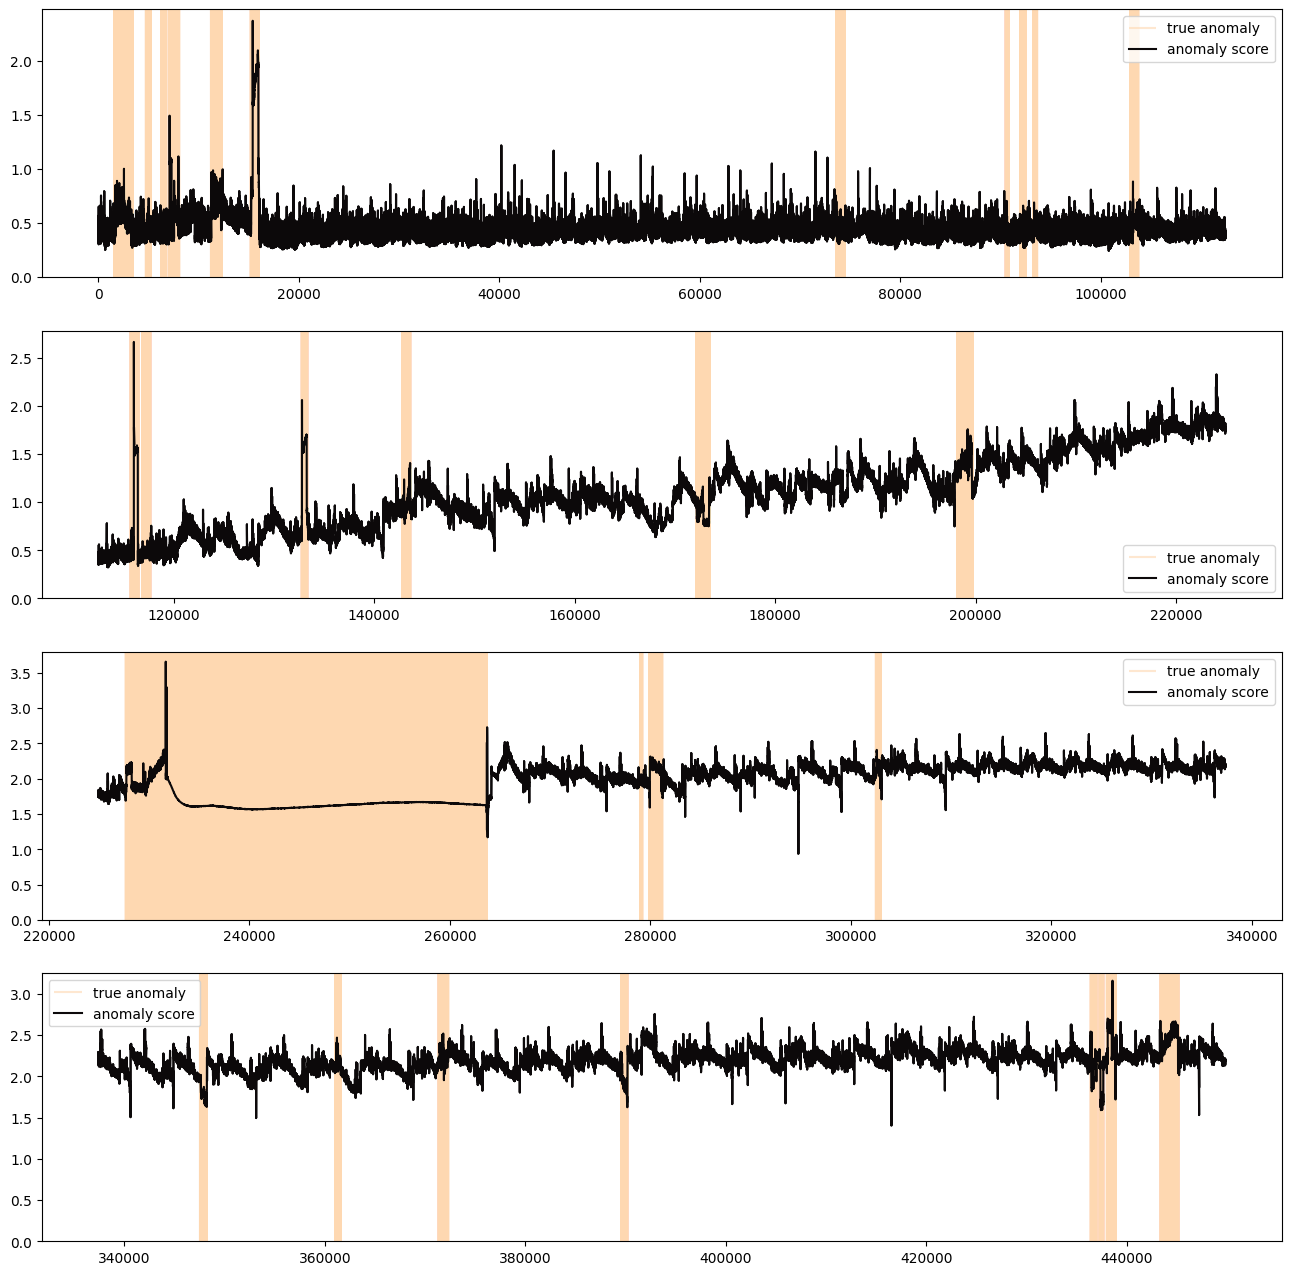

In [81]:
check_score_graph(anomaly_scores, labels, 4)
plt.show()

### STEP 7. Evaluation

In [82]:
# 성능 메트릭 계산 함수
def calc_point2point(predict, actual):
    """
    calculate f1 score by predict and actual.
    Args:
        predict (np.ndarray): the predict label
        actual (np.ndarray): np.ndarray
    """
    TP = np.sum(predict * actual)
    TN = np.sum((1 - predict) * (1 - actual))
    FP = np.sum(predict * (1 - actual))
    FN = np.sum((1 - predict) * actual)
    precision = TP / (TP + FP + 0.00001)
    recall = TP / (TP + FN + 0.00001)
    f1 = 2 * precision * recall / (precision + recall + 0.00001)
    return f1, precision, recall, TP, TN, FP, FN

def bf_search(score, label, start, end=None, step_num=1, display_freq=1, verbose=True) -> object:
    """
    Find the best-f1 score by searching best `threshold` in [`start`, `end`).
    Returns:
        list: list for results
        float: the `threshold` for best-f1
    """
    if step_num is None or end is None:
        end = start
        step_num = 1
    search_step, search_range, search_lower_bound = step_num, end - start, start
    if verbose:
        print("search range: ", search_lower_bound, search_lower_bound + search_range)
    threshold = search_lower_bound
    m = [-1., -1., -1.]
    m_t = 0.0
    for i in range(search_step):
        threshold += search_range / float(search_step)
        predict = score > threshold
        f1, precision, recall, _, _, _, _ = calc_point2point(predict, label)
        if f1 > m[0]:
            m_t = threshold
            m[0] = f1
            m[1] = precision
            m[2] = recall
        if verbose and i % display_freq == 0:
            print(f"cur thr: {threshold:.4f} | F1-score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
    return m, m_t
    
# 성능 평가 함수 정의
def evaluation(score, 
               y_true, 
               start, 
               end=None, 
               step_num=1, 
               display_freq=1, 
               verbose=False, 
               threshold=None):
    
    
    # 임계값이 지정되지 않았으면 탐색 방법에 따라 최적의 임계값을 찾음
    if threshold is None:
        results, threshold = bf_search(score, 
                                       y_true, 
                                       start, 
                                       end, 
                                       step_num, 
                                       display_freq, 
                                       verbose)
    
    # 예측값 생성
    y_pred = np.where(score>=threshold, 1, 0)
    # 이상치에 대한 F1 점수, 정밀도, 재현율 계산
    f1_score, precision, recall, _, _, _, _ = calc_point2point(y_true, y_pred)
    
    # 평가 결과 출력
    print(f'[F1-score]: {f1_score:.4f}, [Precision]: {precision:.4f}, [Recall]: {recall:.4f}, [Threshold]: {threshold:.4f}')
    
    return f1_score, threshold

In [86]:
# 성능 평가를 수행
f1_score, threshold = evaluation(anomaly_scores, 
                                 labels,  # label만 추출
                                 start=min(anomaly_scores),  # 시작 threshold는 평균 점수의 최솟값
                                 end=np.percentile(anomaly_scores, 99),  # 끝 threshold는 평균 점수의 99백분위수
                                 step_num=1000,  # 탐색할 threshold의 개수
                                 display_freq=100,  # 진행 상황을 표시할 빈도
                                 verbose=True)  # 진행 상황을 표시하지 않음

search range:  0.24202743 2.428686201572418
cur thr: 0.2442 | F1-score: 0.2166, Precision: 0.1214, Recall: 1.0000
cur thr: 0.4629 | F1-score: 0.2514, Precision: 0.1450, Recall: 0.9411
cur thr: 0.6815 | F1-score: 0.2591, Precision: 0.1517, Recall: 0.8887
cur thr: 0.9002 | F1-score: 0.2616, Precision: 0.1545, Recall: 0.8528
cur thr: 1.1189 | F1-score: 0.2785, Precision: 0.1670, Recall: 0.8376
cur thr: 1.3375 | F1-score: 0.2945, Precision: 0.1790, Recall: 0.8306
cur thr: 1.5562 | F1-score: 0.2976, Precision: 0.1826, Recall: 0.8035
cur thr: 1.7749 | F1-score: 0.0928, Precision: 0.0593, Recall: 0.2134
cur thr: 1.9935 | F1-score: 0.0704, Precision: 0.0465, Recall: 0.1448
cur thr: 2.2122 | F1-score: 0.0626, Precision: 0.0582, Recall: 0.0678
[F1-score]: 0.2989, [Precision]: 0.8130, [Recall]: 0.1831, [Threshold]: 1.5168


In [87]:
# 찾은 threshold에 대한 confusion matrix 결과
tn, fp, fn, tp = confusion_matrix(labels, np.where(anomaly_scores>=threshold, 1, 0)).ravel()
(tn, fp, fn, tp)

(197066, 198133, 10216, 44405)

---